# G-League to NBA Analysis

### Author: Brian Pang, 2-12-2020

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("C://Users/bpang/Downloads/gleaguestatsdata.csv")

#### Exploratory Data Analysis and More Data Cleaning

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3614 entries, 0 to 3613
Data columns (total 33 columns):
Tm                3614 non-null object
Age               2783 non-null float64
G                 3614 non-null int64
GS                3614 non-null int64
MP                3614 non-null float64
FG                3614 non-null float64
FGA               3614 non-null float64
FG%               3591 non-null float64
3P                3614 non-null float64
3PA               3614 non-null float64
3P%               3200 non-null float64
2P                3614 non-null float64
2PA               3614 non-null float64
2P%               3579 non-null float64
eFG%              3591 non-null float64
FT                3614 non-null float64
FTA               3614 non-null float64
FT%               3445 non-null float64
ORB               3614 non-null float64
DRB               3614 non-null float64
TRB               3614 non-null float64
AST               3614 non-null float64
STL               

In [4]:
data.head(10)

,Tm,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,BLK,TOV,PF,PTS,Player,Season,NBA Minutes,Called Up,Assigned,Two-Way Player
0,TUL,NaN,9,2,22.4,2.2,5.6,0.400,0.1,1.1,...,0.0,1.6,1.8,4.7,Wink Adams,2010,0,0,0,0
1,MAI,25.0,22,19,34.4,5.3,11.2,0.476,1.5,3.5,...,0.2,2.7,2.0,15.6,Maurice Ager,2010,0,0,0,0
2,ABQ,25.0,50,43,32.1,5.2,11.2,0.463,1.9,4.4,...,0.0,1.9,1.5,15.1,Antoine Agudio,2010,0,0,0,0
3,TOT,25.0,30,23,38.1,5.6,13.9,0.401,2.5,7.0,...,0.2,3.1,2.5,19.2,Blake Ahearn,2010,0,0,0,0
4,MAI,21.0,22,21,26.0,5.1,9.4,0.546,0.0,0.1,...,3.1,3.0,3.9,14.6,Alexis Ajinca,2010,1,0,1,0
5,FOR,23.0,6,3,27.0,4.0,10.0,0.400,0.3,0.8,...,0.7,2.5,2.8,10.5,Joe Alexander,2010,1,0,1,0
6,SPR,NaN,1,0,19.0,2.0,8.0,0.250,0.0,0.0,...,1.0,1.0,0.0,7.0,Julian Allen,2010,0,0,0,0
7,ABQ,NaN,15,7,16.7,1.5,2.9,0.523,0.0,0.0,...,2.2,1.2,1.7,3.2,Shagari Alleyne,2010,0,0,0,0
8,IDA,28.0,30,28,31.2,5.9,12.0,0.496,0.0,0.0,...,0.4,1.4,3.0,13.0,Lance Allred,2010,0,0,0,0
9,TOT,24.0,42,39,38.4,7.7,15.2,0.505,1.6,4.1,...,0.1,3.1,2.4,24.6,Morris Almond,2010,0,0,0,0


In [5]:
#Impute the mean for missing values in 'Age'

data['Age'].fillna(round(data['Age'].mean()), inplace = True)

In [6]:
#Replace nan with 0 for rest of data - Nan represents 0/0 - a player never shot that type of field goal - for example if a player never attempted a 3 point shot, their 3 point % is NaN

data.fillna(0, inplace = True)

In [7]:
#Create a new column called NBA Player
#Uses lambda function to go through each row and check each of the 4 columns
def label_NBA_player(row):
    if row['NBA Minutes'] == 1:
        return 1
    elif row['Called Up'] == 1:
        return 1
    elif row['Assigned'] == 1:
        return 1
    elif row['Two-Way Player'] == 1:
        return 1
    else:
        return 0
    
data['NBA_Player'] = data.apply(lambda row: label_NBA_player(row), axis = 1)

Text(0.5, 1.0, 'G League Players')

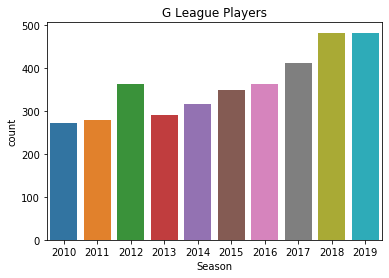

In [8]:
data.head(10)

sns.countplot(x='Season', data = data).set_title('G League Players')

Text(0.5, 1.0, 'NBA Players in G-League Count')

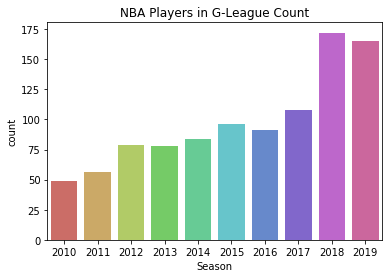

In [9]:
sns.countplot(x='Season', data = data.loc[data.NBA_Player == 1], palette = 'hls').set_title('NBA Players in G-League Count')

In [10]:
#There's a spike in NBA Players starting in 2017-2018 season. This is due to the introduction of two-way contracts
#that allow each NBA team up to 2 players they retain in the G-league and call up for up to 45 days.

NBA_Player_count_by_season = pd.DataFrame(data['Two-Way Player'].groupby(data.Season).agg('sum').copy())
NBA_Player_count_by_season

,Two-Way Player
Season,
2010,0
2011,0
2012,0
2013,0
2014,0
2015,0
2016,0
2017,0
2018,45


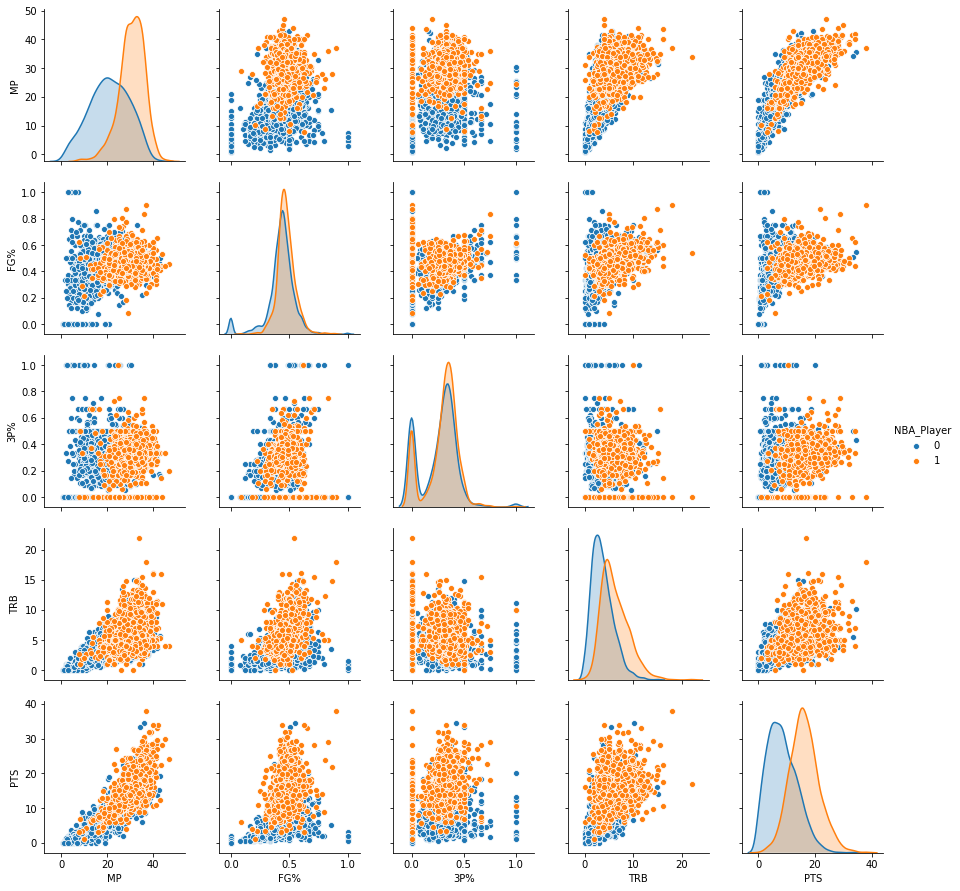

In [11]:
#Scatterplot matrix of a few variables
sns.pairplot(data = data, vars =['MP','FG%', '3P%', 'TRB', 'PTS'] , hue = 'NBA_Player')

## Random Forest

#### Objective: Create a model that predicts which G-league players were an NBA player in the same season.

In [12]:
#Dropping variables used to create the outcome, or irrelevant variables
labels = data.NBA_Player
ml_data = data.drop(['Tm', 'G', 'GS', 'Player', 'NBA Minutes', 'Called Up', 'Assigned', 'Two-Way Player', 'NBA_Player'], axis = 1)

In [13]:
#Use indices for train/test split instead of labels to keep track of which rows of the original dataset are in each set
indices = data.index.values

In [14]:
#Splitting ml_data into training and testing set on 80/20 split
x_train,x_test, indices_train, indices_test = train_test_split(ml_data,indices, test_size = 0.2, random_state = 42)
y_train, y_test = labels[indices_train], labels[indices_test]

In [15]:
training_dataset = data.loc[indices_train]
testing_dataset = data.loc[indices_test]

In [16]:
#Use hyperparameter tuning for random forest to increase model accuracy:

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 10)]
max_features = ['auto', 'sqrt', 'log2', None]
max_depth = [int(x) for x in np.linspace(4,20, num = 8)]
max_depth.append(None)
min_samples_split =[2,5,10]
min_samples_leaf = [1,2,4]
bootstrap= [True, False]


random_grid = {'n_estimators' : n_estimators,
               'max_features' : max_features,
               'max_depth' : max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier(random_state = 42)
rf_model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)


In [17]:
rf_model.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [18]:
rf_model.best_params_

{'n_estimators': 133,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [19]:
best_model = rf_model.best_estimator_

#Model Performance on Testing Set
best_model.score(x_test, y_test)

0.8340248962655602

In [20]:
#Percentage of Players who were non-NBA in the training dataset (Also the baseline score for our model if we were to predict only no)
1-sum(training_dataset.NBA_Player)/len(training_dataset.NBA_Player)

0.7284676582497406

In [21]:
#Confusion matrix on results:
#C0,0= true negatives, C1,1 = true positives, C1,0 = false negatives, C0,1 = false positives
testing_dataset['Tuning_Predictions'] = best_model.predict(x_test)
confusion_matrix(testing_dataset.NBA_Player, testing_dataset.Tuning_Predictions)

array([[480,  50],
       [ 70, 123]], dtype=int64)